# CMPE-255 Data Mining: Group Project
## Group 1: Alex Dodd, Tom Casaletto, Jonathan Conover
Dataset: Bitcoin Heist Ransomeware Address Dataset
https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
%matplotlib inline



#### Assign the heist dataset to a pandas dataframe object

In [2]:
df = pd.read_csv('BitcoinHeistData.csv')
df

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,1.000500e+08,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,1.000000e+08,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,2.000000e+08,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,7.120000e+07,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,2.000000e+08,princetonLocky
...,...,...,...,...,...,...,...,...,...,...
2916692,12D3trgho1vJ4mGtWBRPyHdMJK96TRYSry,2018,330,0,0.111111,1,0,1,1.255809e+09,white
2916693,1P7PputTcVkhXBmXBvSD9MJ3UYPsiou1u2,2018,330,0,1.000000,1,0,1,4.409699e+07,white
2916694,1KYiKJEfdJtap9QX2v9BXJMpz2SfU4pgZw,2018,330,2,12.000000,6,6,35,2.398267e+09,white
2916695,15iPUJsRNZQZHmZZVwmQ63srsmughCXV4a,2018,330,0,0.500000,1,0,1,1.780427e+08,white


## Data Exploration

In [3]:
#Ratio of white to heist data
whiteTrans = df[(df['label'] == 'white')]
heistTrans = df[(df['label'] != 'white')]
print('Percent White Transactions: ' + str(whiteTrans.shape[0]/df.shape[0]))
print('Percent Heist Transactions: ' + str(heistTrans.shape[0]/df.shape[0]))

Percent White Transactions: 0.9858014048082472
Percent Heist Transactions: 0.014198595191752863


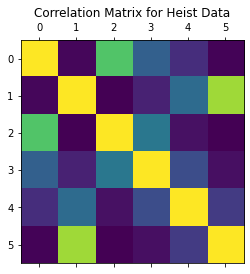

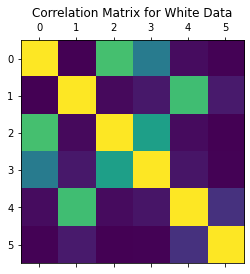

In [4]:
heistTemp = heistTrans.iloc[:,3:9]
plt.matshow(heistTemp.corr())
plt.title("Correlation Matrix for Heist Data")
plt.show()

whiteTemp = whiteTrans.iloc[:,3:9]
plt.matshow(whiteTemp.corr())
plt.title("Correlation Matrix for White Data")
plt.show()

#### The following cell captures the initial assessment of dimensionality reduction being appropriate; it was determined that dimensionality reduction was not appropriate for this dataset and the following cell simply depict the results

[0.36637665 0.30873889 0.15202702 0.11116542 0.041579   0.02011303]
[301.72261649 276.97440461 194.35886606 166.19916166 101.64382268
  70.69402414]


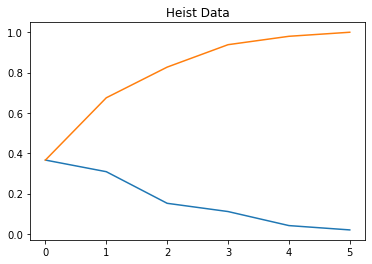

[0.35676674 0.28546505 0.16226005 0.10047181 0.05064837 0.04438799]
[2480.89382143 2219.17969085 1673.09962975 1316.55227777  934.75700114
  875.08195285]


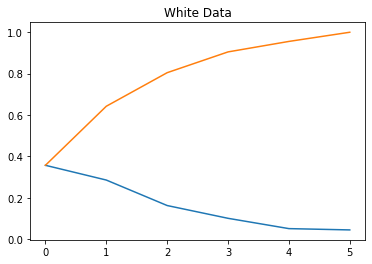

In [5]:
dirtyStd = preprocessing.StandardScaler().fit_transform(heistTemp)
pca = PCA(n_components=6)
pca.fit(dirtyStd)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)
plt.title("Heist Data")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

whiteStd = preprocessing.StandardScaler().fit_transform(whiteTemp)
pca.fit(whiteStd)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.plot(pca.explained_variance_ratio_)
plt.title("White Data")
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()


## Model Training

#### The next two code blocks will assign numerical values for the address cells. Done to avoid losing any context these attributes add to the dataset

In [6]:
uni_addr = df['address'].unique()
print(len(uni_addr))
addr_dict = {}
for i in range(len(uni_addr)):
    addr_dict[uni_addr[i]] = i
print(len(addr_dict))

2631095
2631095


In [7]:
index = df.index
for i in range(len(df['address'])):
    try:
        df.at[index[i],'address'] = int(addr_dict[df['address'][index[i]]])
    except KeyError:
         continue

#### Visual inspect that data replacement occured correctly

In [8]:
df

,address,year,day,length,weight,count,looped,neighbors,income,label
0,0,2017,11,18,0.008333,1,0,2,1.000500e+08,princetonCerber
1,1,2016,132,44,0.000244,1,0,1,1.000000e+08,princetonLocky
2,2,2016,246,0,1.000000,1,0,2,2.000000e+08,princetonCerber
3,3,2016,322,72,0.003906,1,0,2,7.120000e+07,princetonCerber
4,4,2016,238,144,0.072848,456,0,1,2.000000e+08,princetonLocky
...,...,...,...,...,...,...,...,...,...,...
2916692,2631091,2018,330,0,0.111111,1,0,1,1.255809e+09,white
2916693,2631092,2018,330,0,1.000000,1,0,1,4.409699e+07,white
2916694,2177756,2018,330,2,12.000000,6,6,35,2.398267e+09,white
2916695,2631093,2018,330,0,0.500000,1,0,1,1.780427e+08,white


#### Seperate into X and Y and transform the Y labels into either True for White and False for heist. This directly supports our objective to train a model that distinguishes between white and heist transactions.

In [9]:
Y = df['label']
Y = Y.str.contains('white')
X = df.drop(columns=['label'])
print(Y.shape,X.shape)

(2916697,) (2916697, 9)


#### Scale X by MinMaxScaler

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)
X_scale

array([[0.00000000e+00, 8.57142857e-01, 2.74725275e-02, ...,
        0.00000000e+00, 7.74053719e-05, 1.40199911e-06],
       [3.80070039e-07, 7.14285714e-01, 3.59890110e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.40099840e-06],
       [7.60140079e-07, 7.14285714e-01, 6.73076923e-01, ...,
        0.00000000e+00, 7.74053719e-05, 3.40242469e-06],
       ...,
       [8.27699809e-01, 1.00000000e+00, 9.03846154e-01, ...,
        4.13907285e-04, 2.63178265e-03, 4.73991240e-05],
       [9.99999620e-01, 1.00000000e+00, 9.03846154e-01, ...,
        0.00000000e+00, 0.00000000e+00, 2.96296491e-06],
       [1.00000000e+00, 1.00000000e+00, 9.03846154e-01, ...,
        0.00000000e+00, 7.74053719e-05, 1.64817455e-06]])

#### Next two blocks will split the data into a training and test set. Then further split the test set into a test and validation sets; validation set is used while training the neural net for on the spot evaluation

In [11]:
### Split to test and train
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(2333357, 9) (583340, 9) (2333357,) (583340,)


In [12]:
X_val, X_test_net, Y_val, Y_test_net = train_test_split(X_test, Y_test, test_size=0.5)
print(X_val.shape, X_test_net.shape, Y_val.shape, Y_test_net.shape)

(291670, 9) (291670, 9) (291670,) (291670,)


## Create and train the Keras Neural Net 

In [49]:
neural_model = Sequential([
    Dense(32, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

neural_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
hist = neural_model.fit(X_train, Y_train,
          batch_size=32, epochs=5,
          validation_data=(X_val, Y_val))

Epoch 1/5
72918/72918 [==============================] - 44s 588us/step - loss: 0.0274 - accuracy: 0.9937 - val_loss: 0.0016 - val_accuracy: 0.9995
Epoch 2/5
72918/72918 [==============================] - 48s 654us/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0011 - val_accuracy: 0.9997
Epoch 3/5
72918/72918 [==============================] - 60s 820us/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 8.4103e-04 - val_accuracy: 0.9997
Epoch 4/5
72918/72918 [==============================] - 87s 1ms/step - loss: 9.4160e-04 - accuracy: 0.9997 - val_loss: 7.2273e-04 - val_accuracy: 0.9997
Epoch 5/5
72918/72918 [==============================] - 63s 871us/step - loss: 7.6836e-04 - accuracy: 0.9998 - val_loss: 6.4053e-04 - val_accuracy: 0.9998


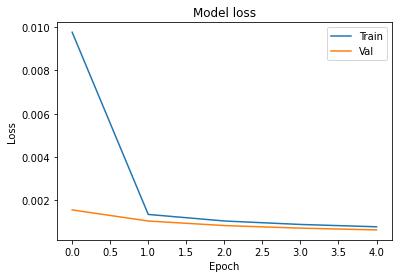

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [51]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

print(hist.history.keys())

#### Evaluate the test set with labels provided and observe accuracy

In [52]:
neural_model.evaluate(X_test, Y_test)[1]

18230/18230 [==============================] - 7s 406us/step - loss: 7.0444e-04 - accuracy: 0.9998


0.9997994303703308

#### Call the predict function against the test set without labels provided for complete evaluation and then compare to the original numbers

In [53]:
# For softmax activation
# np.argmax(model.predict(X_test), axis=-1)

# For sigmoid activiation
classes = (neural_model.predict(X_test) > 0.5).astype("int32")

In [54]:
pred_white = np.count_nonzero(classes == 1) 
pred_heist = np.count_nonzero(classes == 0) 
print("Predicted number white",pred_white)
print("Predicted number heist",pred_heist)

test_white = np.count_nonzero(Y_test == True) 
test_heist = np.count_nonzero(Y_test == False)     
print("Actual number white",test_white)
print("Actual number heist",test_heist)
        

Predicted number white 575238
Predicted number heist 8102
Actual number white 575237
Actual number heist 8103


In [55]:
def scorer(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred)
    r_score = recall_score(y_test, y_pred)
    f_score = f1_score(y_test, y_pred)
    return accuracy, p_score, r_score, f_score

accuracy, p_score, r_score, f_score = scorer(Y_test, classes)
print("The Accuracy is: ",accuracy,"\nThe Precision is: ",p_score,"\nThe Recall is: ",r_score,"\nThe F1 Score is: ",f_score)

The Accuracy is:  0.9997994308636473 
The Precision is:  0.9998974337578532 
The Recall is:  0.9998991719934566 
The F1 Score is:  0.9998983028748994


#### Assessment: the Neural Net is able to correctly distinguish between the white and heist data at a 99.9% accuracy rate. This would allow for future supplied data to be predicted accordingly.

## Create and train the Random Forest Classifier

In [20]:
modelRF = RandomForestClassifier()
modelRF.fit(X_train, Y_train)

RandomForestClassifier()

In [21]:
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelRF, X_val, Y_val, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance



In [22]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

y_predRF = modelRF.predict(X_test)
y_predRF.astype(int)
print(y_predRF)
print(np.unique(y_predRF))

accuracy, p_score, r_score, f_score = scorer(Y_test, y_predRF)
print("The Accuracy is: ",accuracy,"\nThe Precision is: ",p_score,"\nThe Recall is: ",r_score,"\nThe F1 Score is: ",f_score)

Accuracy: 1.000 (0.000)
[ True  True  True ...  True  True  True]
[False  True]
The Accuracy is:  1.0 
The Precision is:  1.0 
The Recall is:  1.0 
The F1 Score is:  1.0


In [23]:
pred_white = np.count_nonzero(y_predRF == True) 
pred_heist = np.count_nonzero(y_predRF == False)
print("Predicted number white",pred_white)
print("Predicted number heist",pred_heist)

test_white = np.count_nonzero(Y_test == True) 
test_heist = np.count_nonzero(Y_test == False)     
print("Actual number white",test_white)
print("Actual number heist",test_heist)
        

Predicted number white 575237
Predicted number heist 8103
Actual number white 575237
Actual number heist 8103


#### Assessment: The Random Forest implementation is able to correctly distinguish between the white and heist data at a 100% accuracy rate. This would allow for future supplied data to be predicted accordingly without error. The Random Forest implementation would be the preferred method.